In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os, time, math, warnings
warnings.filterwarnings('ignore')
import polcal_lib as pln
import numpy as np
from matplotlib import pyplot as plt

### Generating a set of calibration units states
*cal_unit* takes as arguments: [alpha, delta, theta] where

-    alpha == off set of the polarizer(angle)
-    delta == retardance of retarder
-    theta == off set of the retarder 

In [2]:
cl = pln.cal_unit(-0.305, 75.442, 0., angle_rot=None)
#result is a column vector!
print(cl)


[[ 0.5       ]
 [ 0.49997166]
 [-0.00133803]
 [ 0.00515225]]


If you want to generate a full range of calibration states

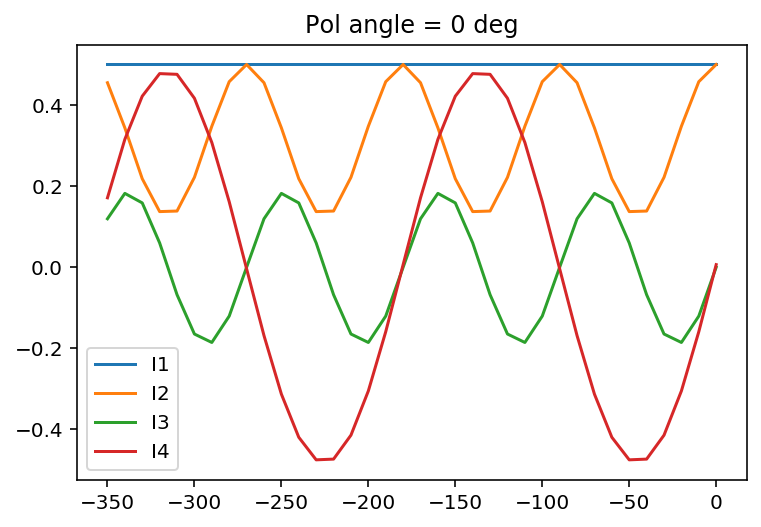

In [3]:
#generate the calibration states (input to instrument)
#def cal_unit(alpha, delta, theta, angle_rot=None):
    #theta = off set of the retarder
    #delta = retardance
    #alpha = off set of the polarizer(angle)
    #theta = np.arange(0, -360, -1)
theta = np.arange(0, -360, -10)
out = np.zeros((4,36))
for i in range(len(theta)):
    out[:,i] = pln.cal_unit(-0.305, 75.442,theta[i]).flatten()
plt.plot(theta, out[0, :], label = 'I1')
plt.plot(theta, out[1, :], label = 'I2')
plt.plot(theta, out[2, :], label = 'I3')
plt.plot(theta, out[3, :], label = 'I4')
plt.title('Pol angle = 0 deg')
plt.legend()
plt.show()


- Instrument model is in pol_model
- input is system parameters (see example below) and rotation angle) 

    #def pol_model(pardata=pardata,angle_rot=0):



In [4]:
pardata = {'delta1' : np.array([225., 225., 315., 315.]),
           'delta2' : np.array([234., 125.26, 54.74, 305.26]),
           'theta1' : 0.0,
           'theta2' : 45.0,
           'pol_angle' : 0.0,
           'rot_inst' : 0.0}

mod_matrix = pln.instrument_model(pardata=pardata)
print(2.*mod_matrix)

[[ 1.         -0.58778525  0.5720614  -0.5720614 ]
 [ 1.         -0.57728771 -0.57738155  0.57738155]
 [ 1.          0.57728771 -0.57738155 -0.57738155]
 [ 1.          0.57728771  0.57738155  0.57738155]]


We can see how the instrument modulates the PCU input

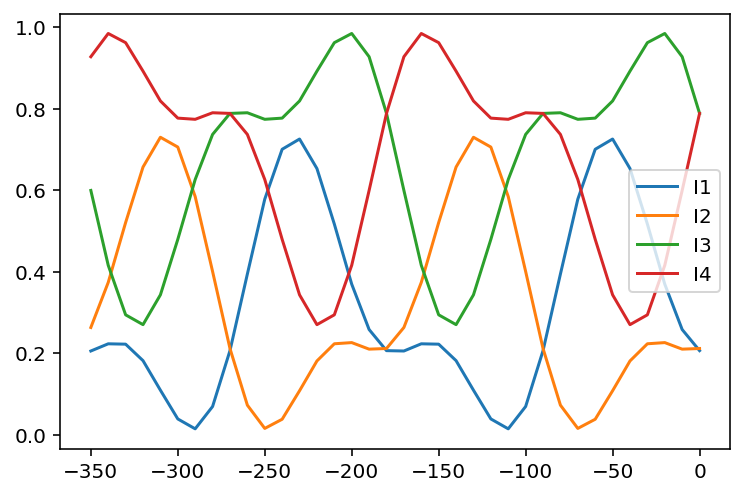

In [5]:
mod_matrix, response = pln.pol_cal_model(alpha=0, delta=75, theta=np.arange(0, -360, -10),pardata=pardata,plot=True)

Lets read some data and compare the output with the model

In [9]:
#leemos los datos
from scipy.io.idl import readsav
file = '../../../../PHI_POLCAL_revisited/datos_FDT_40D_J0.sav'
s = readsav(file)
data = s.data
data = np.einsum('klij->ijkl', data)
#norma = np.max(data[500:1500,500:1500,:,:])
#data = data/norma

In [79]:
read_signal = np.mean(data[1024-200:1024+200,1024-200:1024+200,:,:],axis=(0,1)) 
#normalize around the max:
norma = np.max(data[1024-200:1024+200,1024-200:1024+200,:,:])  
read_signal /= norma
np.savez('signa',read_signal)

10272.0


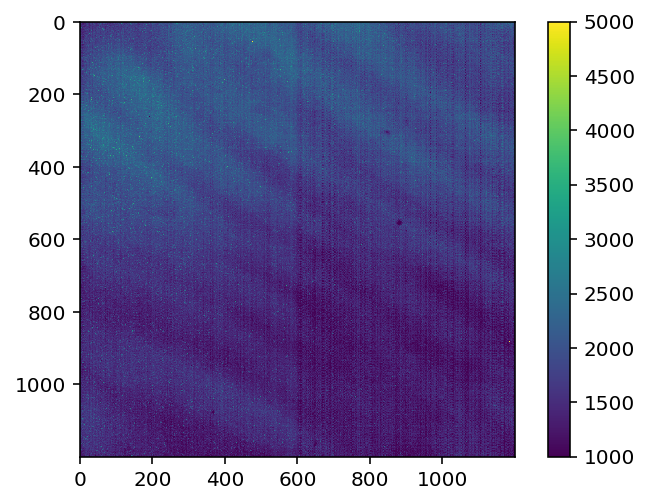

In [85]:
plt.imshow(data[1024-600:1024+600,1024-600:1024+600,11,0],vmax=5000,vmin=1000)
plt.colorbar()
print(data[400,500,12,0])

In [40]:
pardata = {'delta1' : np.array([225., 225., 315., 315.]),
           'delta2' : np.array([234., 125.26, 54.74, 305.26]),
           'theta1' : 0.0,
           'theta2' : 45.0,
           'pol_angle' : 0.0,
           'rot_inst' : 0.0}
theta = np.arange(0, -360, -10) #- 0.631 - 5 #wave plate fast axis angle
'''
#theta = off set of the retarder
#delta = retardance
#alpha = off set of the polarizer(angle)
'''
#el modelo
#-5.76200
mod_matrix, response = pln.pol_cal_model(alpha= - 0.305, delta=75.442, theta=theta,pardata=pardata)

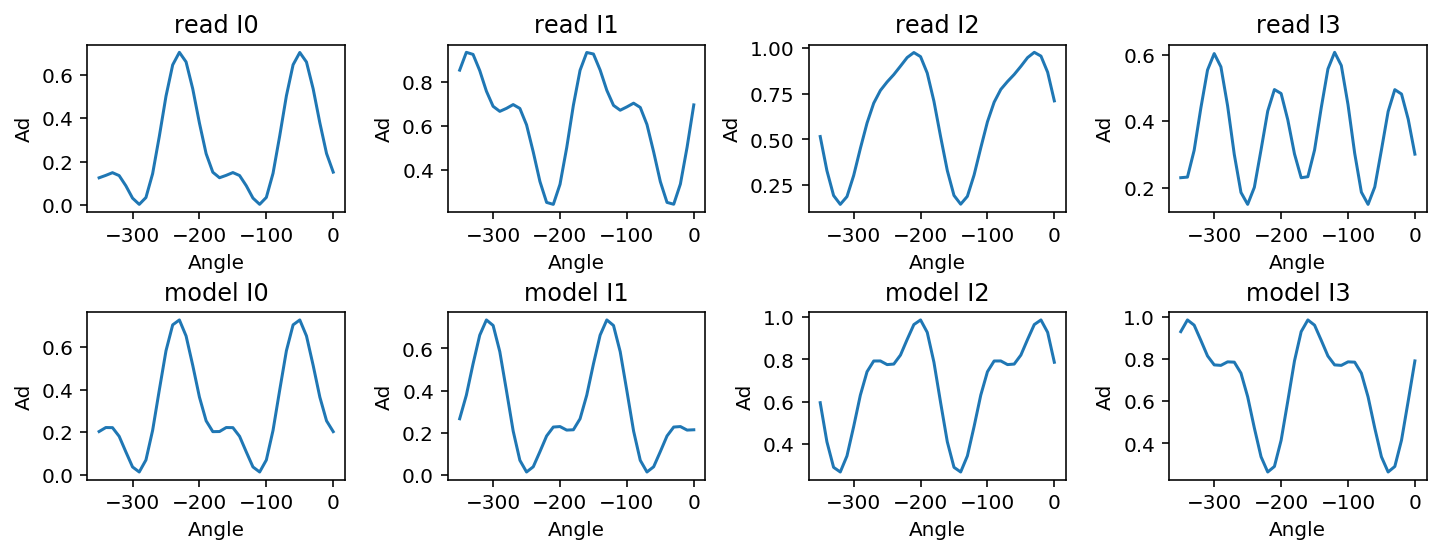

In [78]:
fig, maps = plt.subplots(2,4,figsize=(12,4))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
for i in range(4):
    maps[0,i].plot(theta, read_signal[:,i])
    #maps[0,i].xvline(theta, read_signal[:,i])
    maps[0,i].set_title('read I'+str(i))
    maps[0,i].set_ylabel('Ad')
    maps[0,i].set_xlabel('Angle')
for i in range(4):
    maps[1,i].plot(theta, response[:,i])
    maps[1,i].set_title('model I'+str(i))
    maps[1,i].set_ylabel('Ad')
    maps[1,i].set_xlabel('Angle')

In [42]:
def fit_calib(x,y,plot=None,w_cut=1e-10):
    '''
    input:  calib states (angle,4), obs (angle)
    '''
    xc = np.matmul(x.T,x)
    xi = pln.svd_solve(xc, w_cut=w_cut)
    cf = np.matmul(xi,np.matmul(x.T,y))
    yfit = np.matmul(x,cf)
    cov = np.sqrt(np.sum((yfit - y)**2)/(len(y) - len(xc) + 1.0 ) * xc.diagonal() )
    if plot:
        plt.plot(y,'.')
        plt.plot(yfit,'-')
    return cf,yfit,cov

[[ 0.99815874 -0.69330443  0.36757862 -0.60879972]
 [ 1.007111    0.41572773  0.73942764  0.54370663]
 [ 0.9980789   0.44753933 -0.36971305 -0.81537889]
 [ 1.00512257 -0.38561887 -0.91998251  0.13513902]]


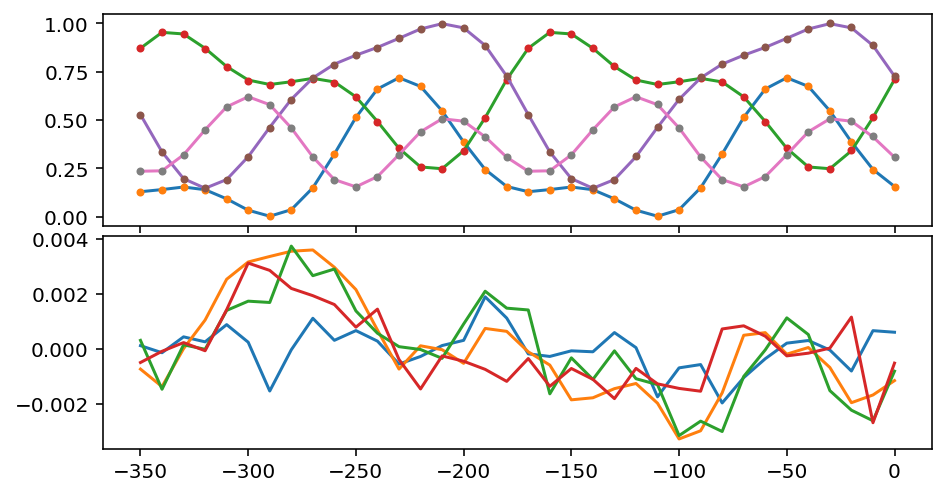

In [89]:
from matplotlib.gridspec import GridSpec

#angulos iniciales para la unidad de calibración 
# que proporciona 36x4 inputs
theta = np.arange(0,-360, -10) 
xdata = np.zeros((36, 4))
for i in range(len(theta)):
    xdata[i,:] = pln.cal_unit(0.335,75.442,theta[i],angle_rot=0).flatten()
#datos leidos en el instrumento (36x4 tambien)
ydata = np.copy(read_signal).astype(float)
modm = np.zeros((4,4))

#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

norm = np.max(ydata)
#ajusto cada una de las medidas por separado Input 36x4 -> output 36x1 
# que representan cada fila de la matrix de modulación
for i in range(4):
    modm[i,:],yfit,cov = fit_calib(xdata,ydata[:,i]/norm,w_cut=1e-20)
    ax1.plot(theta,yfit,'-')
    ax1.plot(theta,ydata[:,i]/norm,'.')
    ax2.plot(theta,yfit - ydata[:,i]/norm,)
    #print(cov)
    #print(np.sum((yfit - ydata[:,i]/norm)**2)/36.)
print(modm)


In [90]:
mod_matrix_40 = np.array([[1.0006,-0.7132, 0.4002,-0.5693],
                            [1.0048, 0.4287,-0.7143, 0.5625],
                            [0.9963, 0.4269,-0.3652,-0.8229],
                            [0.9983,-0.4022, 0.9001, 0.1495]])
demodM = np.linalg.inv(modm)
demodM

array([[ 0.16629391,  0.36727049,  0.16939246,  0.29355931],
       [-0.67405439,  0.30435167,  0.6582878 , -0.28924412],
       [ 0.41231227,  0.34151752, -0.17577132, -0.57710921],
       [-0.35336779,  0.46176175, -0.5780605 ,  0.46225386]])

In [22]:
#Ajuste de un modelo de instrumento. Tal y como está en IDL

#angulos iniciales para la unidad de calibración 
# que proporciona 36x4 inputs
theta = np.arange(0, -360, -10) 
theta = np.tile(theta,4)

#datos leidos en el instrumento (36x4 tambien)
ydata = np.copy(read_signal).astype(float)
norm = np.max(ydata)
#ajusto las cuatro medidas a la vez. Input 36x4 -> output 36x4 en un array de 1D
input_data = (ydata/norm).flatten(order='F')
#input_data = input_data[0:36]

#el modelo de entrada es
#pars = {'delta1' : np.array([225, 225, 315, 315]),
#        'delta2' : np.array([234, 125.26, 54.74, 305.26]),
#        'theta1' : 0,
#        'theta2' : 45,
#        'pol_angle' : 0,
#        'rot_inst' : 0}
#y los correspondientes a la PCU
#        'alpha' : -5.762,  #polarizer offset (PCU)
#        'delta' : 75.52, #retarder retardance (PCU)  theta (retarder angle) is input X
#        'angle_rot' : 0

#Los meto como un numpy array a la función lm_pol_model
input_parameters = np.array([225., 225., 315., 315.,    234.,125.26, 54.74, 305.26,   0.,45.,0.,0.,   -0.762,75.52,0.])
fix = np.array([1,1,1,1  ,1,1,1,1  ,0,0,0,0  ,1,1,0])
model, yfit, sigma, chi2 = pln.lm(theta,input_data,input_parameters,pln.lm_pol_model,niter=30,chi2_stop = 1e-20, 
    fix = fix)
#ilambda = 10, niter = 20, njacobian = True, 
#weights = 1.0, w_cut=1e-10, chi2_stop = 1e-3, cvm = True,istep = 10.):


#figura
fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.plot(input_data,'.')
ax1.plot(yfit,'-')
ax2.plot(yfit - input_data)

print(model)
print(input_parameters)


LinAlgError: SVD did not converge

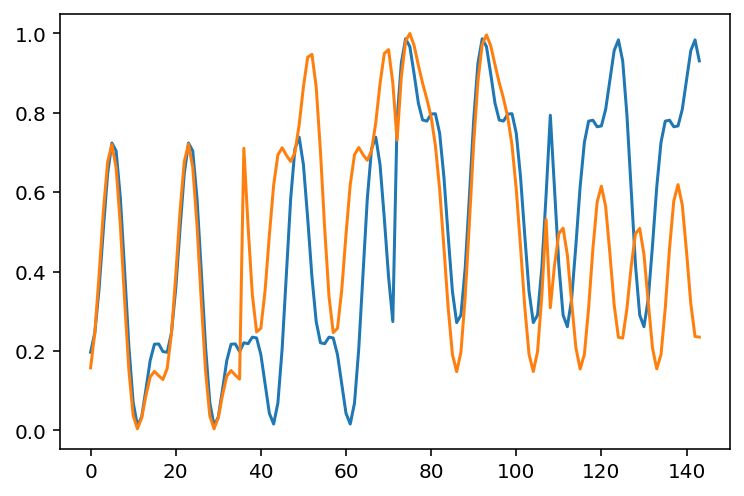

In [13]:
#pln.numerical_der(theta,input_parameters,pln.lm_pol_model)
dd,_ = pln.lm_pol_model(theta,input_parameters)
y,jac = pln.numerical_der(theta,input_parameters,pln.lm_pol_model)
plt.plot(y,'-')
plt.plot(input_data,'-')


In [14]:
a,b = pln.lm_pol_model(theta,input_parameters)

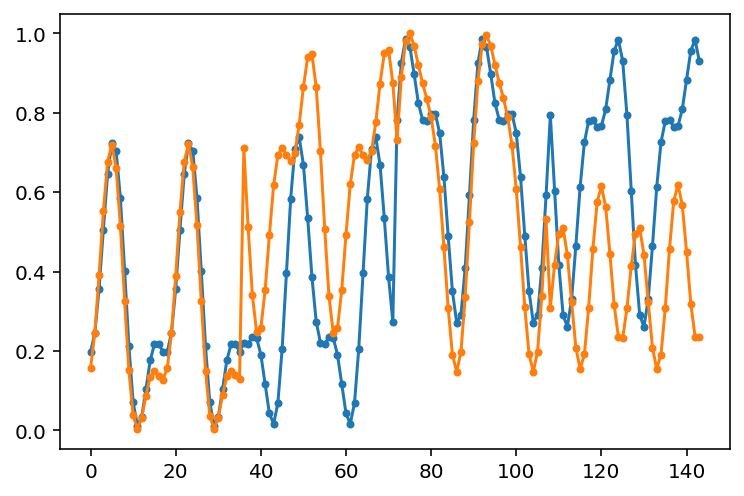

In [15]:
plt.plot(a.flatten(order='F'),'.-')
plt.plot(input_data,'.-')

Iter:   0 Lambda:   1.0000e+01 chi2: 3.21e+01  Yes
Iter:   1 Lambda:   1.0000e+00 chi2: 2.13e+02  Yes
Iter:   2 Lambda:   1.0000e-01 chi2: 4.78e+02  Yes
Iter:   3 Lambda:   1.0000e-02 chi2: 6.06e+02  Yes
Iter:   4 Lambda:   1.0000e-03 chi2: 6.81e+02  Yes
Iter:   5 Lambda:   1.0000e-04 chi2: 4.95e+02  Yes
Iter:   6 Lambda:   1.0000e-05 chi2: 1.26e+02  Yes
Iter:   7 Lambda:   1.0000e-06 chi2: 1.62e+01  Yes
Iter:   8 Lambda:   1.0000e-07 chi2: 1.84e+00  Yes
Iter:   9 Lambda:   1.0000e-08 chi2: 2.05e-01  Yes
Iter:  10 Lambda:   1.0000e-09 chi2: 2.27e-02  Yes
Iter:  11 Lambda:   1.0000e-10 chi2: 2.53e-03  Yes
Iter:  12 Lambda:   1.0000e-11 chi2: 2.81e-04  Yes
STOP because (ochi2 - chi2)/chi2)*100 < chi2_stop
[0.75, 1.7, 2.45] [-0.21747377  1.91658235  2.44420659]


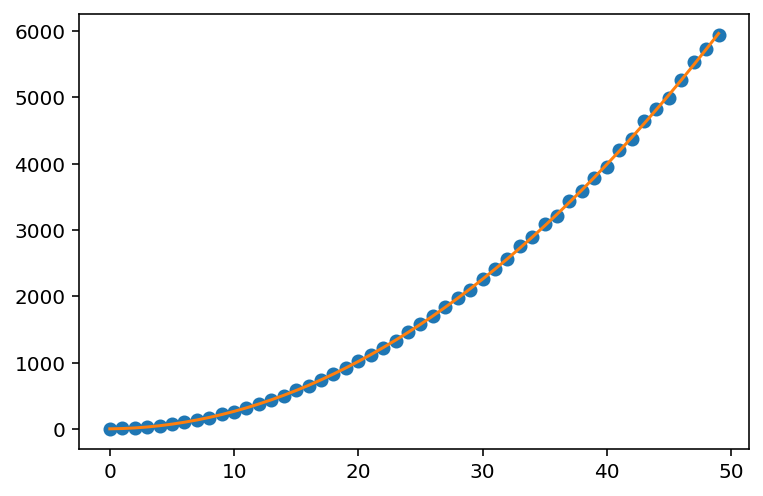

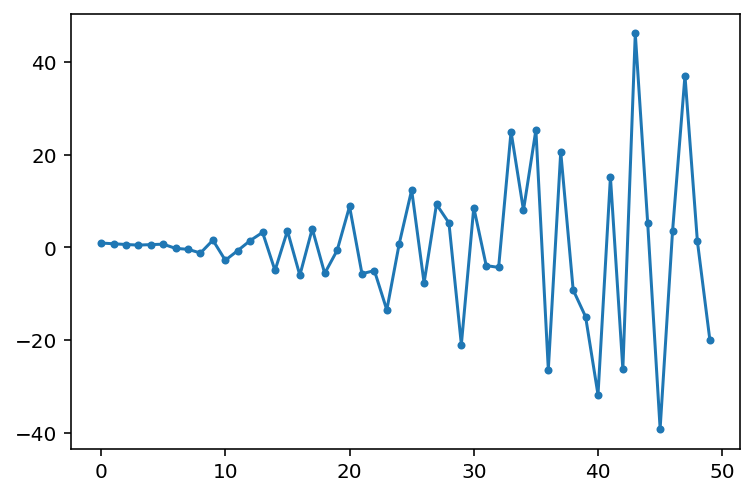

In [16]:
pln.lm_test(njacobian=True)